# **Face Mask Detection**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import time
import os
import copy
import cv2
import matplotlib.pyplot as plt

In [3]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##**Dataset Preparation**

In [10]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

def get_annotations_boxes_from_xml(dir):
    tree = ET.parse(dir)
    root = tree.getroot()

    annotations, labels = [], []

    for neighbor in root.iter('bndbox'):
        xmin = int(neighbor.find('xmin').text)
        ymin = int(neighbor.find('ymin').text)
        xmax = int(neighbor.find('xmax').text)
        ymax = int(neighbor.find('ymax').text)

        annotations.append([xmin, ymin, xmax, ymax])

    for neighbor in root.iter('object'):
        label = neighbor.find('name').text
        if label == 'with_mask':
            labels.append(1)
        elif label == 'without_mask':
            labels.append(2)
        else:
            labels.append(3)

    return annotations, labels



In [12]:
import os
import numpy as np
import torch

from torchvision import transforms
from PIL import Image

class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, 'images'))))
        self.anns = list(sorted(os.listdir(os.path.join(root, 'annotations'))))
        self.img_dir = os.path.join(root, 'images')
        self.ann_dir  = os.path.join(root, 'annotations')

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        curr_img_dir = os.path.join(self.img_dir, self.imgs[idx])
        curr_ann_dir = os.path.join(self.ann_dir, self.anns[idx])

        image = Image.open(curr_img_dir, mode='r').convert('RGB')
        boxes, labels = get_annotations_boxes_from_xml(curr_ann_dir)

        boxes = torch.FloatTensor(boxes)
        labels = torch.LongTensor(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)

        tenn = transforms.ToTensor()
        image = tenn(image)

        return image, boxes, labels

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [13]:
import albumentations as A

data_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

In [14]:
Batch_Size = 16
output_dir = '/content/gdrive/MyDrive/Arete/face_mask_detection/faceMask'
image_datasets = {x: FaceMaskDataset(root=os.path.join(output_dir, x), transforms=None) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True, collate_fn=image_datasets[x].collate_fn) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
dataset_sizes

{'train': 893, 'val': 100, 'test': 110}

In [16]:
from PIL import Image, ImageDraw, ImageFont

def display_boundary(image, boxes, labels, score = None):

    label_to_name = {1: 'Masked', 2: 'No Mask', 3: 'Masked_incorrectly'}
    label_to_color = {1: 'palegreen', 2: 'red', 3: 'blue'}

    transform = torchvision.transforms.ToPILImage()
    image = transform(image)
    boxes = boxes.tolist()
    labels = labels.tolist()

    img_bbox = ImageDraw.Draw(image)
    new_font = ImageFont.truetype(os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSansCondensed-Bold.ttf'), 10)

    for idx in range(len(boxes)):
        img_bbox.rectangle(boxes[idx], outline=label_to_color[labels[idx]], width=2)
        if score == None:
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]],
                          font=new_font, align ="left", fill=label_to_color[labels[idx]])
        else:
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]]+' '+ f"{score[idx].item():.2%}",
                          font=new_font, align ="left", fill=label_to_color[labels[idx]])

    return image

# helper function for image visualization
def display_images(**images):
    """
    Plot images in one rown
    """
    num_images = len(images)
    # plt.figure(figsize=(15,15))
    for idx, (name, image) in enumerate(images.items()):
        # plt.subplot(1, num_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
        plt.show()


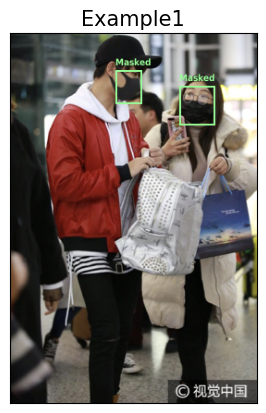

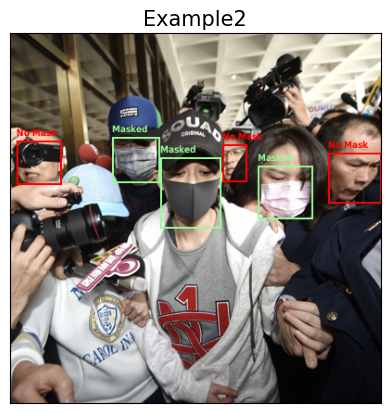

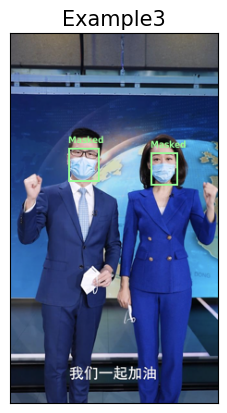

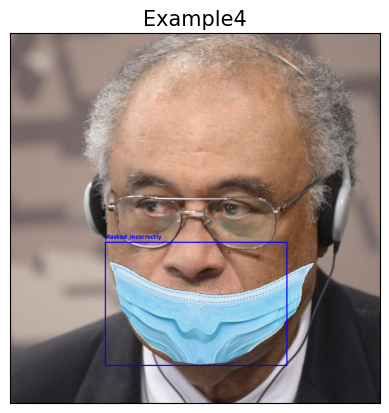

In [17]:
images, boxes, labels = next(iter(dataloaders['train']))

display_images(Example1=display_boundary(images[0], boxes[0], labels[0]),
        Example2=display_boundary(images[1], boxes[1], labels[1]),
        Example3=display_boundary(images[2], boxes[2], labels[2]),
        Example4=display_boundary(images[3], boxes[3], labels[3]))

## **Model Loading**

In [18]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
# model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 83.3MB/s]


## **Training Model**

In [19]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path

# Save the model to the target dir
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    """
    Saves a PyTorch model to a target directory.
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    check_point_name = f"model_epoch_{epoch}"
    model_save_path = target_dir_path / check_point_name

    # Save the model state_dict()
    #print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# Plot the training curve
def plot_curve(results: dict, epochs: int):
    #train_ious, val_ious = np.array(results["train_iou"]), np.array(results["val_iou"])
    train_losses = np.array(results["train_loss"])
    val_losses = np.array(results["val_loss"])

    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(epochs, step=1), val_losses, label='Val loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes
    """
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [20]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import time
# import utils
import numpy as np

from tqdm import trange

class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.DataLoader,
                 epochs: int,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):

        self.model = model
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.epoch = 0
        self.epochs = epochs
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        # Create empty results dictionary
        self.results = {"train_loss": [],
                        "val_loss": [],
                        }

    def train_model(self):
        """
        Train the Model.
        """
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for _ in progressbar:
            # Epoch counter
            self.epoch += 1
            #progressbar.set_description(f"Epoch {self.epoch}")

            # Training block
            self.train_epoch()
            self.val_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]}, Val loss: {self.results["val_loss"][-1]}')

            # Save checkpoints every epoch
            if self.epoch == self.epochs:
              save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # plot training curve
        # plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        """
        Training Mode
        """
        self.model.train() # training mode
        running_losses = []

        for images, boxes, labels in self.train_dataloader:
            # Send to device (GPU or CPU)
            images = list(img.to(self.device) for img in images)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]
            targets = []

            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i]
                d['labels'] = labels[i]
                targets.append(d)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward - track history if only in train
            loss_dict = self.model(images, targets)
            # Calculate the loss
            loss = sum(loss for loss in loss_dict.values())
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Backward pass
            loss.backward()
            # Update the parameters
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))

    def val_epoch(self):
        """
        Validation Mode
        """
        # self.model.eval() # Validation mode
        running_ious, running_losses = [], []

        for images, boxes, labels in self.val_dataloader:
            # Send to device (GPU or CPU)
            images = list(img.to(self.device) for img in images)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]
            targets = []

            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i]
                d['labels'] = labels[i]
                targets.append(d)

            with torch.no_grad():
                loss_dict = self.model(images, targets)
                # Calculate the loss
                loss = sum(loss for loss in loss_dict.values())
                loss_value = loss.item()
                running_losses.append(loss_value)

        self.results["val_loss"].append(np.mean(running_losses))


In [21]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_RCNN = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_RCNN = lr_scheduler.StepLR(optimizer_RCNN, step_size=7, gamma=0.1)

# Trainer
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=25,
                  optimizer=optimizer_RCNN,
                  scheduler=exp_lr_scheduler_RCNN,
                  save_dir="/content/gdrive/MyDrive/Arete/face_mask_detection/RCNN_ModelV2_Output_4C",
                  device=device)



In [22]:
## Training process
model_results = trainer.train_model()


Progress:   4%|▍         | 1/25 [07:36<3:02:29, 456.22s/it]


Epoch 1: Train loss: 0.7585863822272846, Val loss: 0.66647355897086


Progress:   8%|▊         | 2/25 [08:33<1:25:00, 221.76s/it]


Epoch 2: Train loss: 0.6166231765278748, Val loss: 0.6589450325284686


Progress:  12%|█▏        | 3/25 [09:32<53:58, 147.22s/it]  


Epoch 3: Train loss: 0.5889527542250497, Val loss: 0.6382778542382377


Progress:  16%|█▌        | 4/25 [10:31<39:21, 112.45s/it]


Epoch 4: Train loss: 0.5364328207714217, Val loss: 0.603174090385437


Progress:  20%|██        | 5/25 [11:29<30:58, 92.94s/it] 


Epoch 5: Train loss: 0.515955850481987, Val loss: 0.6141074895858765


Progress:  24%|██▍       | 6/25 [12:28<25:43, 81.26s/it]


Epoch 6: Train loss: 0.4878126899046557, Val loss: 0.5773568195956094


Progress:  28%|██▊       | 7/25 [13:27<22:13, 74.10s/it]


Epoch 7: Train loss: 0.4746316277555057, Val loss: 0.5881269403866359


Progress:  32%|███▏      | 8/25 [14:26<19:35, 69.16s/it]


Epoch 8: Train loss: 0.4054680142019476, Val loss: 0.5987773409911564


Progress:  36%|███▌      | 9/25 [15:24<17:33, 65.85s/it]


Epoch 9: Train loss: 0.40048752459032194, Val loss: 0.5878963896206447


Progress:  40%|████      | 10/25 [16:24<15:57, 63.84s/it]


Epoch 10: Train loss: 0.40188911450760706, Val loss: 0.6165259650775364


Progress:  44%|████▍     | 11/25 [17:22<14:29, 62.11s/it]


Epoch 11: Train loss: 0.4002841705722468, Val loss: 0.6471883569444928


Progress:  48%|████▊     | 12/25 [18:21<13:13, 61.05s/it]


Epoch 12: Train loss: 0.4015046272959028, Val loss: 0.6079658993652889


Progress:  52%|█████▏    | 13/25 [19:20<12:05, 60.46s/it]


Epoch 13: Train loss: 0.3924262635409832, Val loss: 0.6347307647977557


Progress:  56%|█████▌    | 14/25 [20:18<10:58, 59.84s/it]


Epoch 14: Train loss: 0.3916403449007443, Val loss: 0.6506071857043675


Progress:  60%|██████    | 15/25 [21:16<09:53, 59.34s/it]


Epoch 15: Train loss: 0.38560510852507185, Val loss: 0.6254669002124241


Progress:  64%|██████▍   | 16/25 [22:15<08:52, 59.17s/it]


Epoch 16: Train loss: 0.3781964337187154, Val loss: 0.6334206121308463


Progress:  68%|██████▊   | 17/25 [23:14<07:52, 59.04s/it]


Epoch 17: Train loss: 0.37836567046386854, Val loss: 0.6724472045898438


Progress:  72%|███████▏  | 18/25 [24:13<06:52, 58.97s/it]


Epoch 18: Train loss: 0.3824207713561399, Val loss: 0.6300973211015973


Progress:  76%|███████▌  | 19/25 [25:12<05:53, 58.99s/it]


Epoch 19: Train loss: 0.38122151525957243, Val loss: 0.5979671563420977


Progress:  80%|████████  | 20/25 [26:10<04:54, 58.86s/it]


Epoch 20: Train loss: 0.3803465174777167, Val loss: 0.6272895676749093


Progress:  84%|████████▍ | 21/25 [27:09<03:54, 58.69s/it]


Epoch 21: Train loss: 0.38027441820928026, Val loss: 0.6358881081853595


Progress:  88%|████████▊ | 22/25 [28:07<02:56, 58.76s/it]


Epoch 22: Train loss: 0.3756809601826327, Val loss: 0.6296521467821938


Progress:  92%|█████████▏| 23/25 [29:06<01:57, 58.64s/it]


Epoch 23: Train loss: 0.3784711126770292, Val loss: 0.6361040643283299


Progress:  96%|█████████▌| 24/25 [30:04<00:58, 58.65s/it]


Epoch 24: Train loss: 0.37608022934624125, Val loss: 0.6340797713824681

Epoch 25: Train loss: 0.38013981602021624, Val loss: 0.6507212264197213


Progress: 100%|██████████| 25/25 [31:04<00:00, 74.58s/it]



--------------------
Training complete in 31m 4s


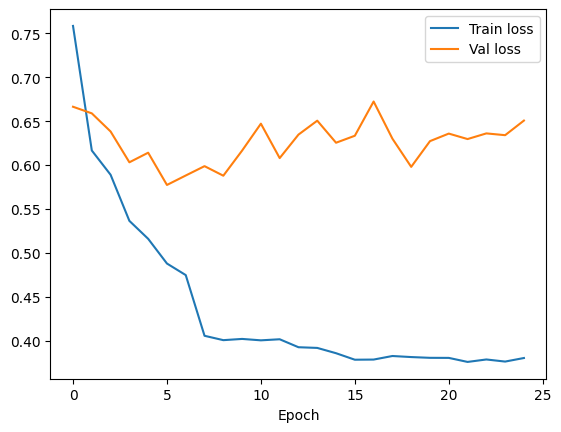

In [32]:
plot_curve(results=trainer.results, epochs=trainer.epochs)

## **Evaluation on Testset**

In [23]:
import torch.optim as optim
from torch.optim import lr_scheduler

model_state = torch.load('/content/gdrive/MyDrive/Arete/face_mask_detection/RCNN_ModelV2_Output_4C/model_epoch_25',map_location=torch.device(device))
model.load_state_dict(model_state)

## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer_UNet = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

In [30]:
def remove_low_risk_box(predictions, threshold):

    for img in range(len(predictions)):
        for idx in range(predictions[img]['labels'].shape[0]):
            if predictions[img]['scores'][idx] < threshold:
                predictions[img]['boxes'] = predictions[img]['boxes'][0:idx]
                predictions[img]['labels'] = predictions[img]['labels'][0:idx]
                predictions[img]['scores'] = predictions[img]['scores'][0:idx]
                break

    return predictions

def nms_pytorch(P : torch.tensor, labels: torch.tensor, scores: torch.tensor, thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract coordinates for every
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    #scores = P[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for
    # filtered prediction boxes
    pred_dict = {'boxes':[], 'labels':[], 'scores':[]}

    while len(order) > 0:

        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        if len(pred_dict['boxes']) == 0:
            pred_dict['boxes'].append(torch.unsqueeze(P[idx], dim=0))
            pred_dict['labels'].append(torch.unsqueeze(labels[idx], dim=0))
            pred_dict['scores'].append(torch.unsqueeze(scores[idx], dim=0))
        else:
            pred_dict['boxes'][0] = torch.cat((pred_dict['boxes'][0], torch.unsqueeze(P[idx], dim=0)), dim=0)
            pred_dict['labels'][0] = torch.cat((pred_dict['labels'][0], torch.unsqueeze(labels[idx], dim=0)), dim=0)
            pred_dict['scores'][0] = torch.cat((pred_dict['scores'][0], torch.unsqueeze(scores[idx], dim=0)), dim=0)

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]

        # find the IoU of every prediction in P with S
        IoU = inter / union
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]

    if len(pred_dict['labels'])>0:
      pred_dict['boxes'], pred_dict['labels'], pred_dict['scores'] = pred_dict['boxes'][0], pred_dict['labels'][0], pred_dict['scores'][0]
    return pred_dict

def apply_nms(predictions, threshold):
    nms_list = []
    for img in range(len(predictions)):
        nms_list.append(nms_pytorch(predictions[img]['boxes'], predictions[img]['labels'], predictions[img]['scores'], threshold))
    return nms_list

In [26]:
images, boxes, labels = next(iter(dataloaders['test']))
images = list(img.to(device) for img in images)

model.eval()
predictions = model(images)
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)


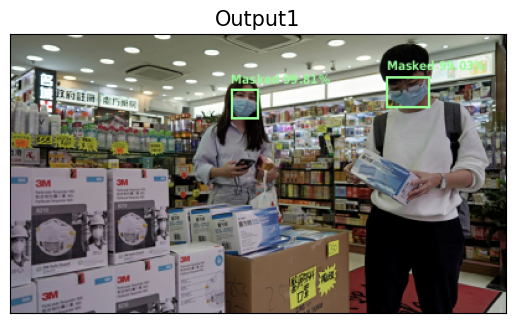

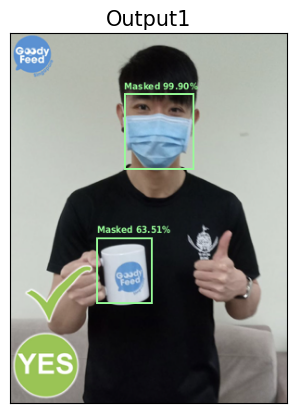

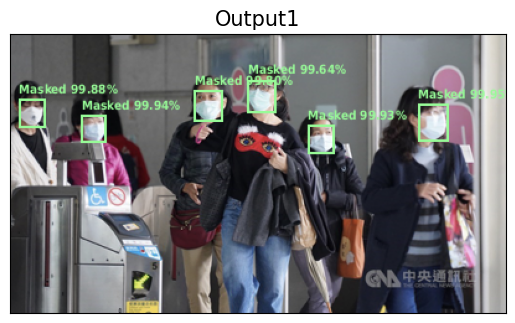

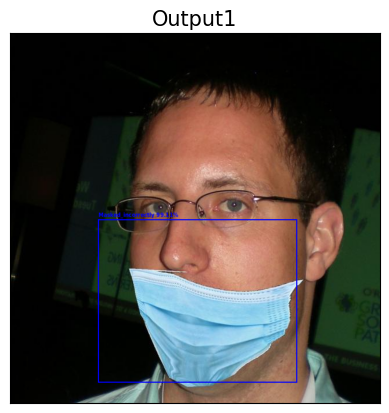

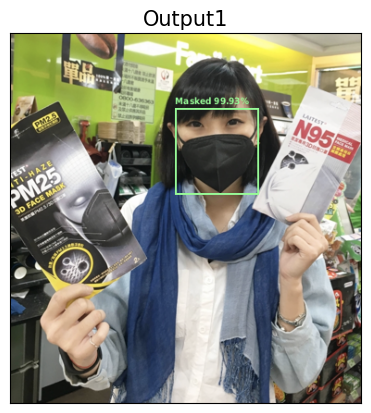

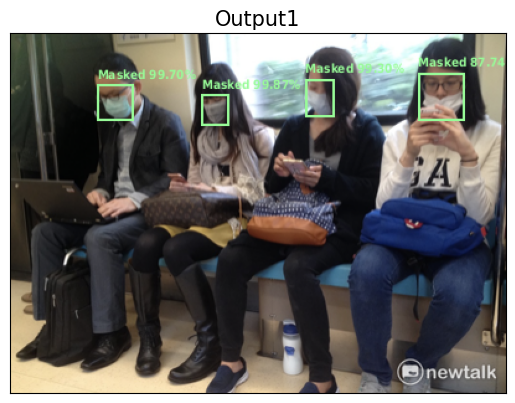

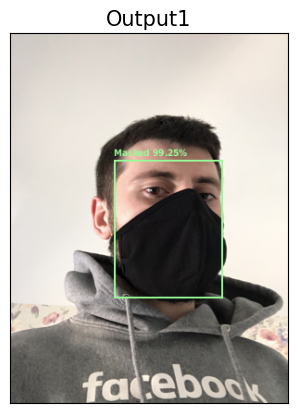

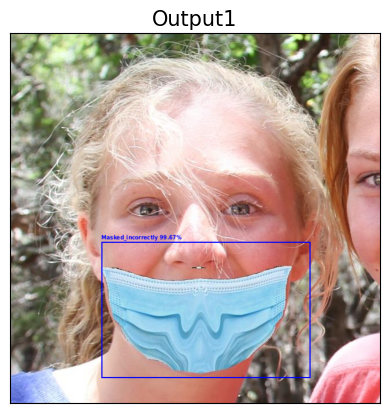

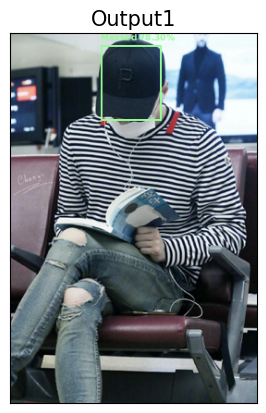

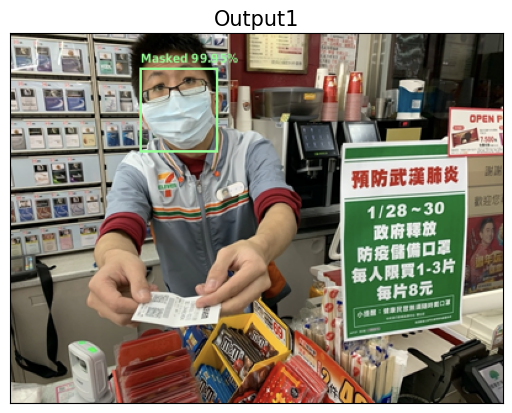

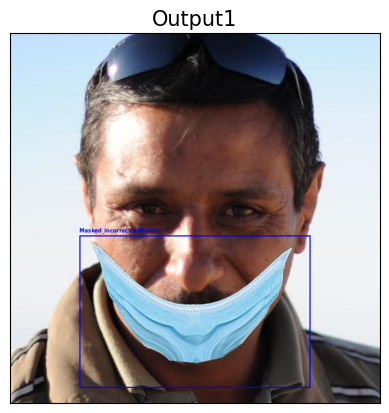

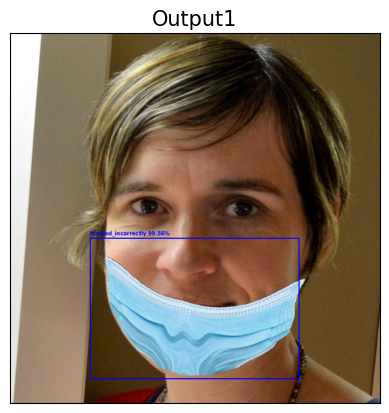

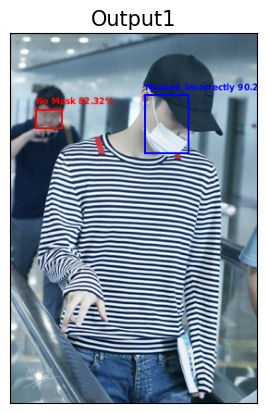

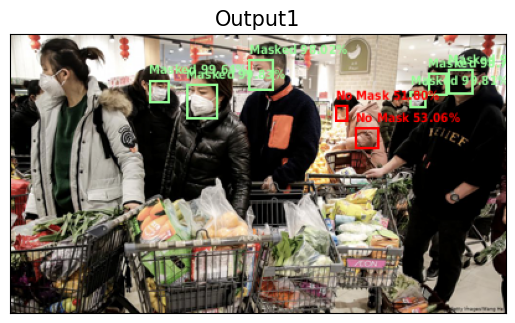

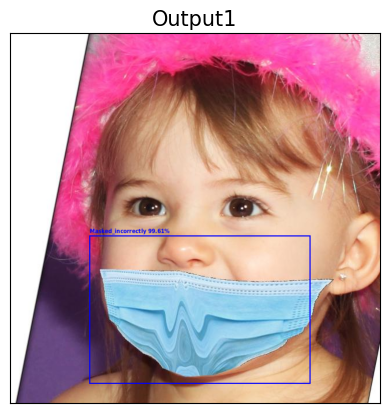

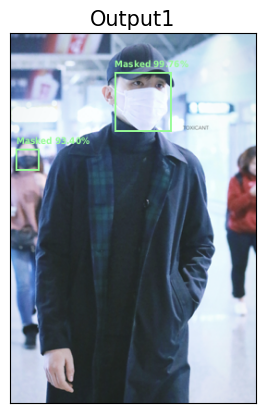

In [29]:
for i in range(16):
  display_images(Output1=display_boundary(images[i], predictions[i]['boxes'],predictions[i]['labels'], predictions[i]['scores']),)

